# ПРОЕКТ - ПРОМЫШЛЕННОСТЬ

<font size="5"><b><u>Описание проекта</b></u></font>
<br>Металлургический комбинат "Стальная птица" проводит оптимизацию производственных расходов. 
<br>Для достижения этой цели необходимо уменьшить потребление электроэнергии на этапе обработки стали. 
<br>Для этого необходимо контролировать температуру сплава.

<font size="3"><b>Задача:</b> построить модель, которая будет предсказывать температуру сплава.</font> 

<font size="3"><b>Описание данных</b></font> 
<br>Данные состоят из нескольких файлов, полученных из разных источников:
- data_arc_new.csv — данные об электродах;
- data_bulk_new.csv — данные о подаче сыпучих материалов (объём);
- data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);
- data_gas_new.csv — данные о продувке сплава газом;
- data_temp_new.csv — результаты измерения температуры;
- data_wire_new.csv — данные о проволочных материалах (объём);
- data_wire_time_new.csv — данные о проволочных материалах (время).

---

<font size="3">Структура файла <b>data_arc_new.csv:</b></font> 
- key — номер партии;
- Начало нагрева дугой — время начала нагрева;
- Конец нагрева дугой — время окончания нагрева;
- Активная мощность — значение активной мощности;
- Реактивная мощность — значение реактивной мощности.

---

<font size="3">Структура файла <b>data_bulk_new.csv:</b></font> 
- key — номер партии;
- Bulk 1 … Bulk 15 — объём подаваемого материала.

---

<font size="3">Структура файла <b>data_bulk_time_new.csv:</b></font>
- key — номер партии;
- Bulk 1 … Bulk 15 — время подачи материала.

---

<font size="3">Структура файла <b>data_gas_new.csv:</b></font>
- key — номер партии;
- Газ 1 — объём подаваемого газа.

---

<font size="3">Структура файла <b>data_temp_new.csv:</b></font>
- key — номер партии;
- Время замера — время замера;
- Температура — значение температуры.

---

<font size="3">Структура файла <b>data_wire_new.csv:</b></font>
- key — номер партии;
- Wire 1 … Wire 9 — объём подаваемых проволочных материалов.

---

<font size="3">Структура файла <b>data_wire_time_new.csv:</b></font>
- key — номер партии;
- Wire 1 … Wire 9 — время подачи проволочных материалов.

## ЗАГРУЗКА ДАННЫХ

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline

from catboost import CatBoostRegressor

RANDOM_STATE = 100325 # по условиям проекта

In [2]:
path = 'industry_info/' # для проверки на личном ПК

In [3]:
data_arc_new = pd.read_csv(path + 'data_arc_new.csv')
data_bulk_new = pd.read_csv(path + 'data_bulk_new.csv')
data_bulk_time_new = pd.read_csv(path + 'data_bulk_time_new.csv')
data_gas_new = pd.read_csv(path + 'data_gas_new.csv')
data_temp_new = pd.read_csv(path + 'data_temp_new.csv')
data_wire_new = pd.read_csv(path + 'data_wire_new.csv')
data_wire_time_new = pd.read_csv(path + 'data_wire_time_new.csv')

In [4]:
data_arc_new.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


Данные файла data_arc_new.csv соответствуют заявленному описанию. Но для аккуратности/сокращения и единообразия обозначений переименуем столбцы

In [5]:
data_arc_new = data_arc_new.rename(columns={'Начало нагрева дугой': 'start_heating', 'Конец нагрева дугой': 'stop_heating',
                           'Активная мощность': 'active_power', 'Реактивная мощность': 'reactive_power'})
data_arc_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   key             14876 non-null  int64  
 1   start_heating   14876 non-null  object 
 2   stop_heating    14876 non-null  object 
 3   active_power    14876 non-null  float64
 4   reactive_power  14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


Файл data_arc_new.csv содержит 14876 строк и 5 столбцов, пропусков в данных нет.

In [6]:
data_bulk_new.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


Данные файла data_bulk_new.csv соответствуют заявленному описанию. Но для аккуратности/сокращения и единообразия обозначений переименуем столбцы. Поскольку мы знаем из описания, что есть два файла с одноименными столбцами в данном случае добавим к наименованиям "vol", чтобы обозначить отношение данных к объему материалов.

In [7]:
data_bulk_new.columns = ['key', 'bulk_1_vol', 'bulk_2_vol', 'bulk_3_vol', 'bulk_4_vol', 'bulk_5_vol', 'bulk_6_vol', 
                         'bulk_7_vol', 'bulk_8_vol', 'bulk_9_vol', 'bulk_10_vol', 'bulk_11_vol',
                         'bulk_12_vol', 'bulk_13_vol', 'bulk_14_vol', 'bulk_15_vol']
data_bulk_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          3129 non-null   int64  
 1   bulk_1_vol   252 non-null    float64
 2   bulk_2_vol   22 non-null     float64
 3   bulk_3_vol   1298 non-null   float64
 4   bulk_4_vol   1014 non-null   float64
 5   bulk_5_vol   77 non-null     float64
 6   bulk_6_vol   576 non-null    float64
 7   bulk_7_vol   25 non-null     float64
 8   bulk_8_vol   1 non-null      float64
 9   bulk_9_vol   19 non-null     float64
 10  bulk_10_vol  176 non-null    float64
 11  bulk_11_vol  177 non-null    float64
 12  bulk_12_vol  2450 non-null   float64
 13  bulk_13_vol  18 non-null     float64
 14  bulk_14_vol  2806 non-null   float64
 15  bulk_15_vol  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.3 KB


Файл data_bulk_new.csv содержит 3129 строк и 16 столбцов, пропуски есть в каждом столбце за исключением столбца key.

In [8]:
data_bulk_time_new.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


Данные файла data_bulk_time_new.csv соответствуют заявленному описанию. Но для аккуратности/сокращения и единообразия обозначений переименуем столбцы. По аналогии с предыдущим файлом добавим к наименованиям столбца "time", чтобы обозначить отношение данных ко времени.

In [9]:
data_bulk_time_new.columns = ['key', 'bulk_1_time', 'bulk_2_time', 'bulk_3_time', 'bulk_4_time', 'bulk_5_time', 
                              'bulk_6_time', 'bulk_7_time', 'bulk_8_time', 'bulk_9_time', 'bulk_10_time', 
                              'bulk_11_time', 'bulk_12_time', 'bulk_13_time', 'bulk_14_time', 'bulk_15_time']
data_bulk_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   key           3129 non-null   int64 
 1   bulk_1_time   252 non-null    object
 2   bulk_2_time   22 non-null     object
 3   bulk_3_time   1298 non-null   object
 4   bulk_4_time   1014 non-null   object
 5   bulk_5_time   77 non-null     object
 6   bulk_6_time   576 non-null    object
 7   bulk_7_time   25 non-null     object
 8   bulk_8_time   1 non-null      object
 9   bulk_9_time   19 non-null     object
 10  bulk_10_time  176 non-null    object
 11  bulk_11_time  177 non-null    object
 12  bulk_12_time  2450 non-null   object
 13  bulk_13_time  18 non-null     object
 14  bulk_14_time  2806 non-null   object
 15  bulk_15_time  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.3+ KB


Файл data_bulk_time_new.csv содержит 3129 строк и 16 столбцов, пропуски есть в каждом столбце за исключением столбца key, соотношение пропусков по столбцам совпадает с файлом data_bulk_new.csv

In [10]:
data_gas_new.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


Данные файла data_gas_new.csv соответствуют заявленному описанию. По аналогии с предыдущими файлами переименуем столбец "Газ 1"

In [11]:
data_gas_new.columns = ['key', 'gas_vol']
data_gas_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3239 non-null   int64  
 1   gas_vol  3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


Файл data_gas_new.csv содержит 3239 строк и 2 столбца, пропусков в данных нет

In [12]:
data_temp_new.head()

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


Данные файла data_temp_new.csv соответствуют заявленному описанию. По аналогии с предыдущими файлами переименуем столбцы

In [13]:
data_temp_new.columns = ['key', 'time', 'temp']
data_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     18092 non-null  int64  
 1   time    18092 non-null  object 
 2   temp    14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


Файл data_temp_new.csv содержит 18092 строки и 3 столбца, пропуски только в столбце с данными о температуре (temp)

In [14]:
data_wire_new.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Данные файла data_wire_new соответствуют заявленному описанию. По аналогии с предыдущими файлами переименуем столбцы

In [15]:
data_wire_new.columns = ['key', 'wire_1_vol', 'wire_2_vol', 'wire_3_vol', 'wire_4_vol', 
                         'wire_5_vol', 'wire_6_vol', 'wire_7_vol', 'wire_8_vol', 'wire_9_vol']
data_wire_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         3081 non-null   int64  
 1   wire_1_vol  3055 non-null   float64
 2   wire_2_vol  1079 non-null   float64
 3   wire_3_vol  63 non-null     float64
 4   wire_4_vol  14 non-null     float64
 5   wire_5_vol  1 non-null      float64
 6   wire_6_vol  73 non-null     float64
 7   wire_7_vol  11 non-null     float64
 8   wire_8_vol  19 non-null     float64
 9   wire_9_vol  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


Файл содержит 3081 строку, пропуски есть во всех столбцах за исключением столбца key

In [16]:
data_wire_time_new.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Структура файла data_wire_time_new.csv соответствует заявленному описанию. По аналогии с предыдущими файлами переименуем столбцы

In [17]:
data_wire_time_new.columns = ['key', 'wire_1_time', 'wire_2_time', 'wire_3_time', 'wire_4_time', 
                              'wire_5_time', 'wire_6_time', 'wire_7_time', 'wire_8_time', 'wire_9_time']
data_wire_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   key          3081 non-null   int64 
 1   wire_1_time  3055 non-null   object
 2   wire_2_time  1079 non-null   object
 3   wire_3_time  63 non-null     object
 4   wire_4_time  14 non-null     object
 5   wire_5_time  1 non-null      object
 6   wire_6_time  73 non-null     object
 7   wire_7_time  11 non-null     object
 8   wire_8_time  19 non-null     object
 9   wire_9_time  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


Файл data_wire_time_new.csv содержить 3081 строку и 10 столбцов. Во всех столбцах за исключением столбца key есть пропуски.

<b>Вывод загрузки данных:</b> для построения модели представлены данные в 7 файлах. Все файлы соответствуют заявленному описанию.
<br>Всего два файла не содержат пропусков в данных: data_arc_new.csv и data_gas_new.csv.
<br>Файл <b>data_arc_new.csv</b> содержит 14875 строк и 5 столбцов.
<br>Файл <b>data_gas_new.csv</b> содержит 3239 строк и 2 столбца.
<br>Файлы <b>data_bulk_new.csv</b> и <b>data_bulk_time_new.csv</b> схожи по структуре, содержат 3129 строк и 16 столбцов, пропуски есть в каждом столбце за исключением столбца key. 
<br>Также схожи по структуре файлы <b>data_wire_new.csv</b> и <b>data_wire_time_new.csv</b>, содержат 3081 строку и 10 столбцов, пропуски есть в каждом столбце за исключением столбца key.
<br>Файл <b>data_temp_new.csv</b> содержит 18092 строку и 3 столбца, пропуски только в столбце с данными о температуре (temp). Из данных о температуре этого файла будет формироваться целевой признак.

## ИССЛЕДОВАТЕЛЬСКИЙ АНАЛИЗ И ПРЕДОБРАБОТКА ДАННЫХ

Посмотрим есть ли повторяющиеся строки в данных

In [18]:
print('Количество повторяющихся строк в датафрейме data_arc_new:', 
     data_arc_new.duplicated().sum())
print('Количество повторяющихся строк в датафрейме data_gas_new:', 
     data_gas_new.duplicated().sum())
print('Количество повторяющихся строк в датафрейме data_bulk_new:', 
     data_bulk_new.duplicated().sum())
print('Количество повторяющихся строк в датафрейме data_bulk_time_new:', 
     data_bulk_time_new.duplicated().sum())
print('Количество повторяющихся строк в датафрейме data_wire_new:', 
     data_wire_new.duplicated().sum())
print('Количество повторяющихся строк в датафрейме data_wire_time_new:', 
     data_wire_time_new.duplicated().sum())
print('Количество повторяющихся строк в датафрейме data_temp_new:', 
     data_temp_new.duplicated().sum())

Количество повторяющихся строк в датафрейме data_arc_new: 0
Количество повторяющихся строк в датафрейме data_gas_new: 0
Количество повторяющихся строк в датафрейме data_bulk_new: 0
Количество повторяющихся строк в датафрейме data_bulk_time_new: 0
Количество повторяющихся строк в датафрейме data_wire_new: 0
Количество повторяющихся строк в датафрейме data_wire_time_new: 0
Количество повторяющихся строк в датафрейме data_temp_new: 0


Повторяющихся строк среди данных нет

Для начала более детально рассмотрим файл data_arc_new. Он не содержит пропусков и дает представление о времени затраченном на тех. процесс для каждой партии. 

In [19]:
data_arc_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   key             14876 non-null  int64  
 1   start_heating   14876 non-null  object 
 2   stop_heating    14876 non-null  object 
 3   active_power    14876 non-null  float64
 4   reactive_power  14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


Преобразуем тип object во временные переменные, а точнее в секунды. В секундах будет удобнее сравнивать значения и проводить над ними математические операции, поскольку сами даты нас не интерисуют, а важна только длительность процессов

In [20]:
data_arc_new.start_heating = pd.to_datetime(data_arc_new.start_heating)
data_arc_new.stop_heating = pd.to_datetime(data_arc_new.stop_heating)
data_arc_new['start_heating'] = data_arc_new['start_heating'].apply(lambda x: x.timestamp())
data_arc_new['stop_heating'] = data_arc_new['stop_heating'].apply(lambda x: x.timestamp())

In [21]:
data_arc_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   key             14876 non-null  int64  
 1   start_heating   14876 non-null  float64
 2   stop_heating    14876 non-null  float64
 3   active_power    14876 non-null  float64
 4   reactive_power  14876 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 581.2 KB


Рассмотрим распределения переменных датафрейма data_acr_new

In [22]:
def graph_quantity_data(df, column, title, xlabel):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    df[column].plot(kind='hist', bins=100, ax=axes[0])
    plt.grid()
    axes[0].set_title(title)
    axes[0].set_xlabel(xlabel)
    axes[0].set_ylabel('Количество появлений')
    df[column].plot(kind='box', ax=axes[1])
    axes[1].set_title('Диаграмма размаха')
    plt.show()

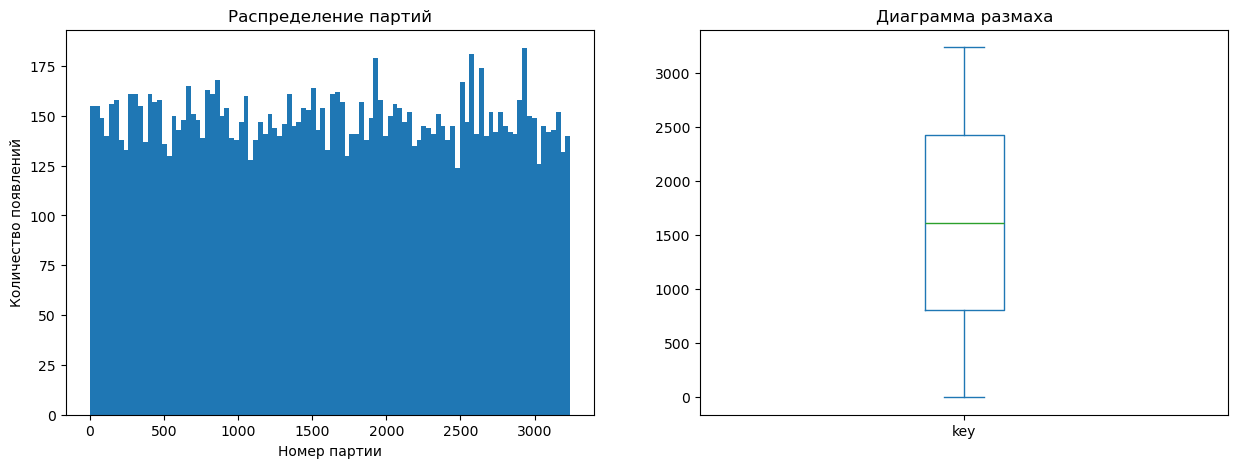

In [23]:
graph_quantity_data(data_arc_new, 'key', 'Распределение партий', 'Номер партии')

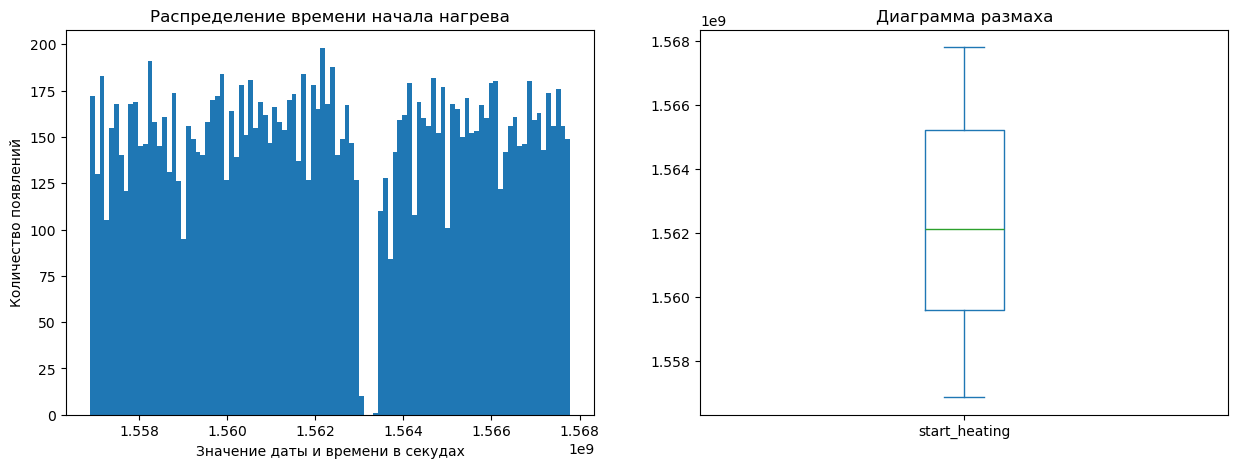

In [24]:
graph_quantity_data(data_arc_new, 'start_heating', 'Распределение времени начала нагрева', 'Значение даты и времени в секудах')

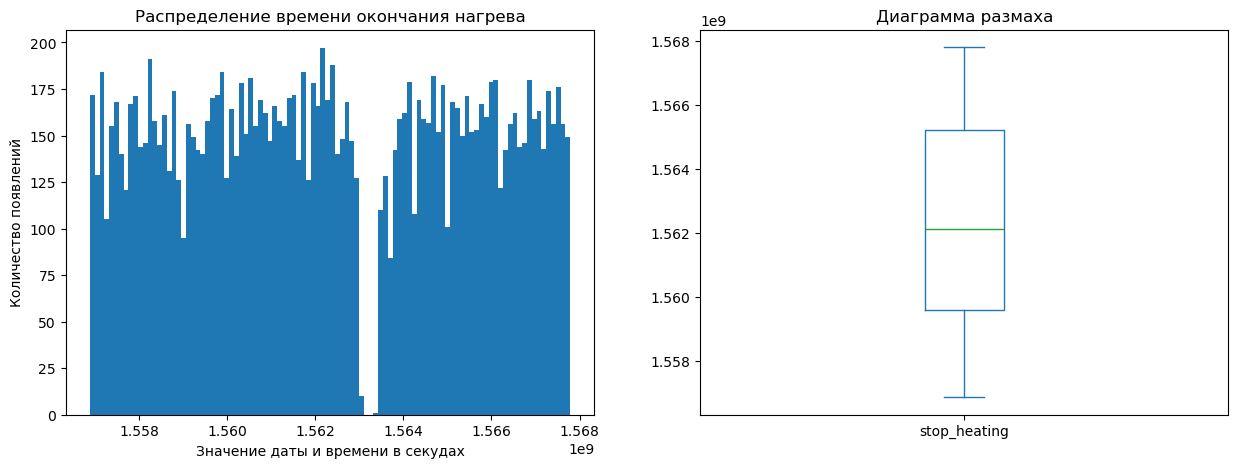

In [25]:
graph_quantity_data(data_arc_new, 'stop_heating', 'Распределение времени окончания нагрева', 'Значение даты и времени в секудах')

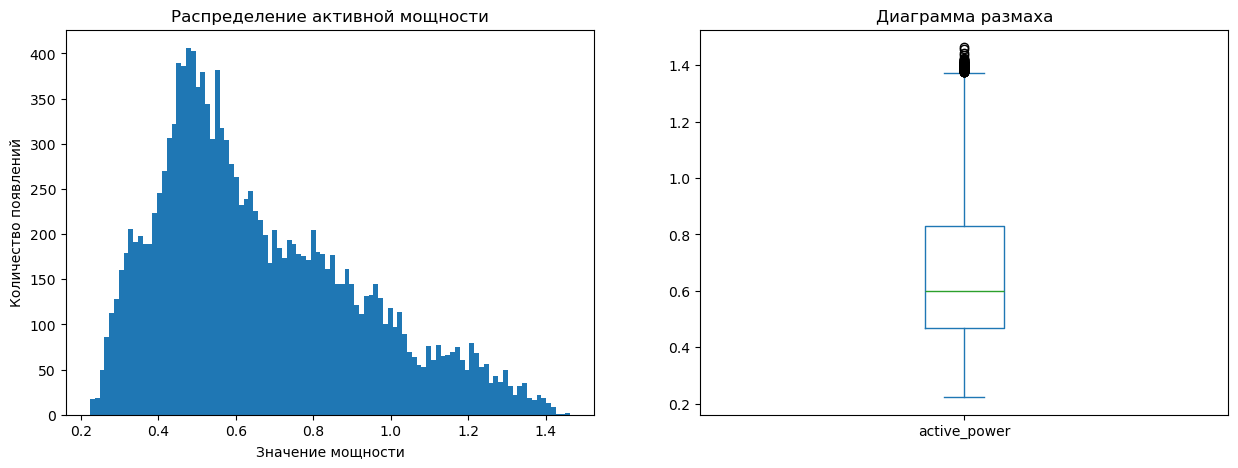

In [26]:
graph_quantity_data(data_arc_new, 'active_power', 'Распределение активной мощности', 'Значение мощности')

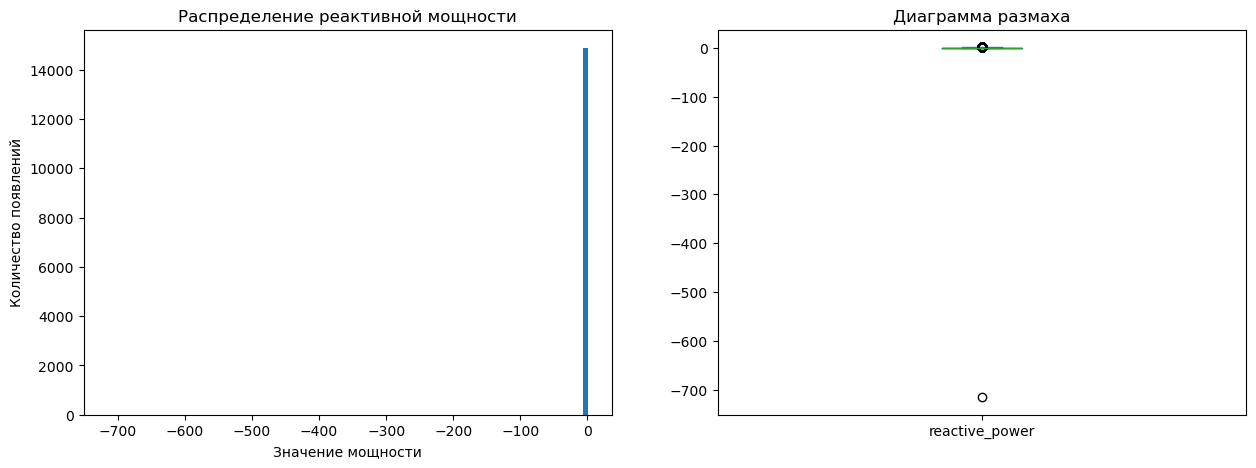

In [27]:
graph_quantity_data(data_arc_new, 'reactive_power', 'Распределение реактивной мощности', 'Значение мощности')

Выявлены аномальные значения реактивной мощности. Посмотрим к каким партиям относятся эти значения

In [28]:
data_error = data_arc_new.query('reactive_power < 0')
data_key = data_error['key'].unique()
data_key

array([2116], dtype=int64)

Выявлено всего одно аномальное значение. Оно относится к техпроцессу партии 2116. Рассмотрим все данные этой партии.

In [29]:
data_error = data_arc_new.query('key == 2116')
data_error

,key,start_heating,stop_heating,active_power,reactive_power
9778,2116,1.564280e+09,1.564280e+09,0.787549,0.693881
9779,2116,1.564280e+09,1.564280e+09,0.580263,0.411498
9780,2116,1.564281e+09,1.564281e+09,0.705344,-715.479924
9781,2116,1.564281e+09,1.564281e+09,0.563641,0.408513


В партии всего 4 нагрева было. Аномальное значение относится к реактивной мощности третьего нагрева, приэтом активная мощность имеет адекватное значение. По величине реактивная мощность немного мень значения активной мощности, оценим среднеей отклонение значений реактивной мощности от значений активной мощности в этой партии и заменим аномальное значение более приближенным к действительности. 

In [30]:
# реализуем функцию, которая будет менять аномальные значения (реактивная мощность < 0) 
# на среднее значение отклонений реактивной мощностит от активной в заданной партии
def correct(df, data_key):
    for elem in data_key:
        data_error = df.query(f'key == {elem}')
        ind = data_error.query('reactive_power < 0').index
        data_error = data_error.query('reactive_power > 0')
        data_error['delta_power'] = data_error['active_power'] / data_error['reactive_power'] 
        coeff = data_error['delta_power'].agg('mean')
        for elem in ind:
            df.at[elem, 'reactive_power'] = df.at[elem, 'active_power'] / coeff
    return df

In [31]:
data_arc_new = correct(data_arc_new, data_key)
data_arc_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   key             14876 non-null  int64  
 1   start_heating   14876 non-null  float64
 2   stop_heating    14876 non-null  float64
 3   active_power    14876 non-null  float64
 4   reactive_power  14876 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 581.2 KB


C:\Users\vasal\AppData\Local\Temp\ipykernel_9112\1872694155.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_error['delta_power'] = data_error['active_power'] / data_error['reactive_power']


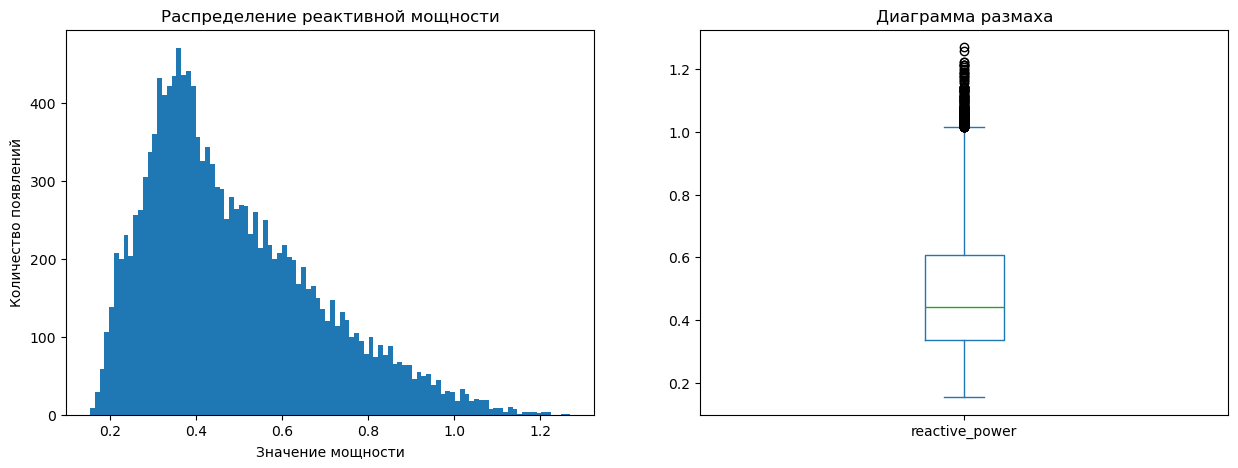

In [32]:
graph_quantity_data(data_arc_new, 'reactive_power', 'Распределение реактивной мощности', 'Значение мощности')

Поскольку мы рассматриваем технологический процесс в общем: без детализации, логичнее будет объединить активную и реактивные части в полную мощность. Сформируем отдельный столбец с данными о мощности и назовем его power

In [33]:
data_arc_new['power'] = (data_arc_new['active_power']**2 + data_arc_new['reactive_power'])**0.5
data_arc_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   key             14876 non-null  int64  
 1   start_heating   14876 non-null  float64
 2   stop_heating    14876 non-null  float64
 3   active_power    14876 non-null  float64
 4   reactive_power  14876 non-null  float64
 5   power           14876 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 697.4 KB


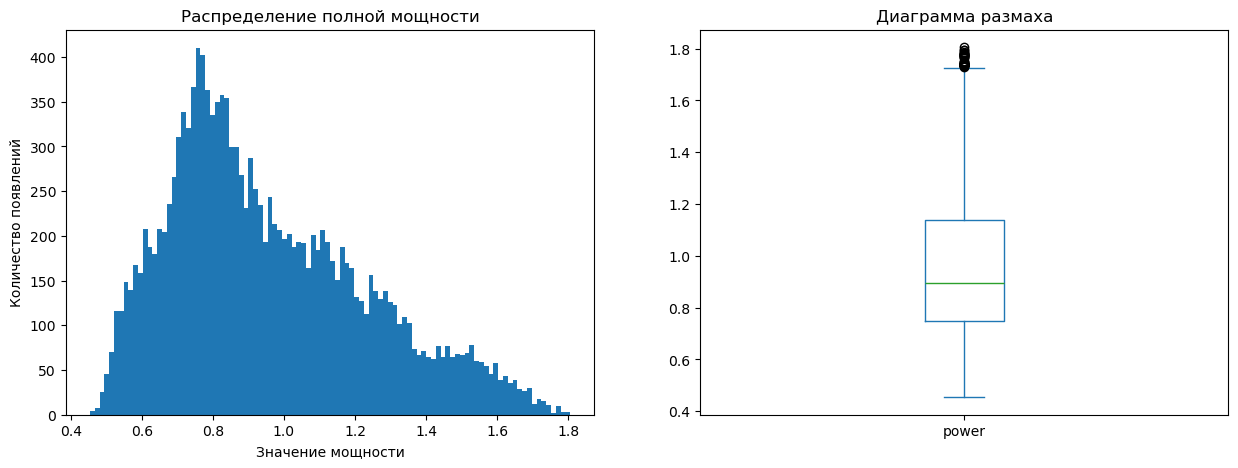

In [34]:
graph_quantity_data(data_arc_new, 'power', 'Распределение полной мощности', 'Значение мощности')

Все аномальные значения data_arc_new либо удалены, либо преобразованы.
<br>Сформируем новую таблицу данных (<b>data_arc</b>) с номером партии (<b>key</b>), суммарным значением времени нагрева электродов (<b>arc_time_median</b>) и суммарным значением полной мощности (<b>power_median</b>). Для этого в исходном датафрейме создадим столбец с временем нагрева и посмотрим на его распределение.

In [35]:
data_arc_new['delta_time'] = data_arc_new['stop_heating'] - data_arc_new['start_heating'] 
data_arc_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   key             14876 non-null  int64  
 1   start_heating   14876 non-null  float64
 2   stop_heating    14876 non-null  float64
 3   active_power    14876 non-null  float64
 4   reactive_power  14876 non-null  float64
 5   power           14876 non-null  float64
 6   delta_time      14876 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 813.7 KB


In [36]:
data_arc = pd.DataFrame(data_arc_new.groupby(by=['key'])['delta_time'].agg('sum'))
data_arc = pd.merge(data_arc, 
                    pd.DataFrame(data_arc_new.groupby(by=['key'])['power'].agg('sum')),
                    left_index=True, right_index=True)
data_arc.columns = ['time_sum', 'power_sum']
data_arc.head()

,time_sum,power_sum
key,,
1,1098.0,4.445794
2,811.0,3.200241
3,655.0,5.562058
4,741.0,3.927138
5,869.0,3.426655


Теперь с учетом знаний техпроцессов из data_arc_new более детально рассмотрим данные data_temp_new.

In [37]:
data_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     18092 non-null  int64  
 1   time    18092 non-null  object 
 2   temp    14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


По аналогии с предыдущим датафрэймом переведем время в секунды

In [38]:
data_temp_new.time = pd.to_datetime(data_temp_new.time)
data_temp_new['time'] = data_temp_new['time'].apply(lambda x: x.timestamp())
data_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     18092 non-null  int64  
 1   time    18092 non-null  float64
 2   temp    14665 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 424.2 KB


Видно, что в признаке температура есть достаточное количество пропусков в данных, заменим их значение 0, для удобства обработки

In [39]:
data_temp_new['temp'] = data_temp_new['temp'].fillna(0)
data_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     18092 non-null  int64  
 1   time    18092 non-null  float64
 2   temp    18092 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 424.2 KB


Нулевых знаений достаточно большое количество, отказ от такого количества партий может привести к недостаточному обучению модели, поэтому главное проверить, чтобы нулевые значения температур не принадлежали к первому и последнему замеру. Но на первом шаге мы прверим, чтобы на одну партию приходилось минимум два измерения (первое и последнее соответственно).

In [40]:
# Проверка на наличие хотябы двух замеров на одну партию
data_temp_grouped = data_temp_new.groupby(by=['key']).agg('count')
data_grouped_error = data_temp_grouped.query('temp < 2')
data_grouped_error.head()

,time,temp
key,,
195,1,1
279,1,1


Партий с одним замером температуры обнаружено всего две. Эти партии удаляем

In [41]:
data_temp_new = data_temp_new.query('key != 195 & key != 279')
data_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18090 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     18090 non-null  int64  
 1   time    18090 non-null  float64
 2   temp    18090 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 565.3 KB


In [42]:
# Проверка на наличие нулевого значения температуры в первом замере
data_temp_grouped = data_temp_new.groupby(by=['key']).agg('first')
data_grouped_error = data_temp_grouped.query('temp == 0')
data_grouped_error.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    0 non-null      float64
 1   temp    0 non-null      float64
dtypes: float64(2)
memory usage: 0.0 bytes


Партий с отсутствием первого замера не найдено. Проверим последние замеры, которые также являются целевым признаком

In [43]:
# Проверка на наличие нулевого значения температуры в последнем замере
data_temp_grouped = data_temp_new.groupby(by=['key']).agg('last')
data_grouped_error = data_temp_grouped.query('temp == 0')
data_grouped_error.info()

<class 'pandas.core.frame.DataFrame'>
Index: 739 entries, 2500 to 3241
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    739 non-null    float64
 1   temp    739 non-null    float64
dtypes: float64(2)
memory usage: 17.3 KB


Обнаружено 739 партий, в которых отсутсвуют последние замеры температуры. Их мы удаляем из данных для обучения модели 

In [44]:
data_temp_new.set_index('key', inplace=True)
data_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18090 entries, 1 to 3241
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    18090 non-null  float64
 1   temp    18090 non-null  float64
dtypes: float64(2)
memory usage: 424.0 KB


In [45]:
data_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18090 entries, 1 to 3241
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    18090 non-null  float64
 1   temp    18090 non-null  float64
dtypes: float64(2)
memory usage: 424.0 KB


In [46]:
data_temp_new.drop(data_grouped_error.index, inplace=True)
data_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13924 entries, 1 to 2499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    13924 non-null  float64
 1   temp    13924 non-null  float64
dtypes: float64(2)
memory usage: 326.3 KB


Также рассмотрим одинаково ли количество измерений в каждой партии

In [47]:
# Расчет количества значений для каждой партии
data_temp_grouped = data_temp_new.groupby(by=['key']).agg('count')
data_temp_grouped.temp.unique()

array([ 6,  5,  7,  4,  8, 13, 11, 14,  2,  3,  9, 10, 12, 16, 17],
      dtype=int64)

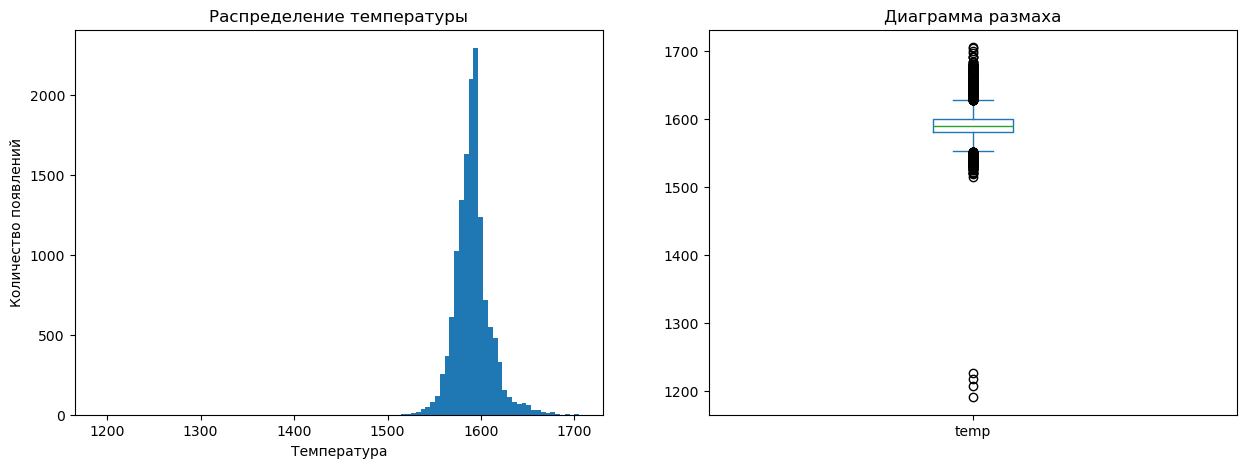

In [48]:
graph_quantity_data(data_temp_new, 'temp', 'Распределение температуры', 'Температура')

В распределении температуры выявлены аномальные значения. Посмотрим к каким партиям относятся эти значения.

In [49]:
data_error = data_temp_new.query('temp < 1500')
data_error

,time,temp
key,,
867,1.559808e+09,1191.0
1214,1.560845e+09,1208.0
1619,1.562121e+09,1218.0
2052,1.564045e+09,1227.0


Выявлено всего четыре аномальных значения. Они относятся к техпроцессам партий 867, 1214, 1619, 2052. Поскольку 4 партии это незначительное значение в рамках общего исследования удалим все данные этих партий.

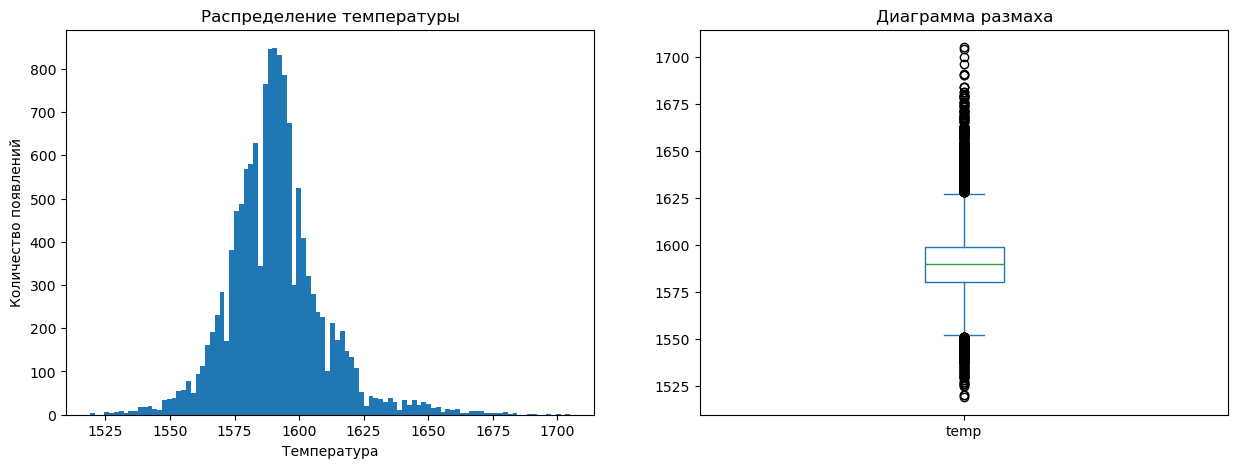

In [50]:
data_temp_new = data_temp_new.query('key != 867 & key != 1214 & key != 1619 & key != 2052')
graph_quantity_data(data_temp_new, 'temp', 'Распределение температуры', 'Температура')

Все аномальные значения data_temp_new удалены, а также партии проверены на наличие первых и последних замеров температрц.
<br>Необходимо выделить целевой признак: последний замер температуры. 
<br>Сформируем новую таблицу данных (<b>data_temp</b>) с номером партии (<b>key</b>), значением начальной температуры (<b>temp_start</b>), значение последнего замера температуры (<b>temp_end</b>), разницой времени между первым и последним замером (<b>delta_time</b>) и количеством промежуточных замеров (без учета первого и последнего) (<b>count</b>).

In [51]:
data_temp = pd.DataFrame(data_temp_new.groupby(by=['key'])['temp'].agg('first'))
data_temp = pd.merge(data_temp, 
                     pd.DataFrame(data_temp_new.groupby(by=['key'])['temp'].agg('last')),
                     left_index=True, right_index=True)
data_temp = pd.merge(data_temp, 
                     pd.DataFrame(data_temp_new.groupby(by=['key'])['time'].agg('last'))
                     - pd.DataFrame(data_temp_new.groupby(by=['key'])['time'].agg('first')),
                     left_index=True, right_index=True)
data_temp = pd.merge(data_temp, 
                     pd.DataFrame(data_temp_new.groupby(by=['key'])['temp'].agg('count'))-2,
                     left_index=True, right_index=True)
data_temp.columns = ['temp_start', 'temp_end', 'delta_time', 'count']
data_temp.head()

,temp_start,temp_end,delta_time,count
key,,,,
1,1571.0,1613.0,1714.0,4
2,1581.0,1602.0,1265.0,3
3,1596.0,1599.0,1753.0,4
4,1601.0,1625.0,1220.0,3
5,1576.0,1602.0,1536.0,3


Переходим к файлу data_bulk_new

In [52]:
data_bulk_new.head()

,key,bulk_1_vol,bulk_2_vol,bulk_3_vol,bulk_4_vol,bulk_5_vol,bulk_6_vol,bulk_7_vol,bulk_8_vol,bulk_9_vol,bulk_10_vol,bulk_11_vol,bulk_12_vol,bulk_13_vol,bulk_14_vol,bulk_15_vol
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


Поскольку столбцов очень много и чтобы не рассматривать распределения каждой добавки сформируем новую таблицу данных (<b>data_bulk</b>) с номером партии (<b>key</b>), суммарным значением объема добавок (<b>bulk_vol</b>) и количеством добавок (<b>bulk_count</b>).

In [53]:
data_bulk_new = data_bulk_new.set_index('key')

In [54]:
data_bulk_new['bulk_vol'] = data_bulk_new.agg('sum', axis=1)
data_bulk_new['bulk_count'] = data_bulk_new.agg('count', axis=1) - 1
data_bulk = data_bulk_new.drop(['bulk_1_vol', 'bulk_2_vol', 'bulk_3_vol', 'bulk_4_vol', 'bulk_5_vol', 'bulk_6_vol', 
                         'bulk_7_vol', 'bulk_8_vol', 'bulk_9_vol', 'bulk_10_vol', 'bulk_11_vol',
                         'bulk_12_vol', 'bulk_13_vol', 'bulk_14_vol', 'bulk_15_vol'], axis=1)
data_bulk.head()

,bulk_vol,bulk_count
key,,
1,553.0,4
2,582.0,4
3,544.0,4
4,595.0,4
5,584.0,4


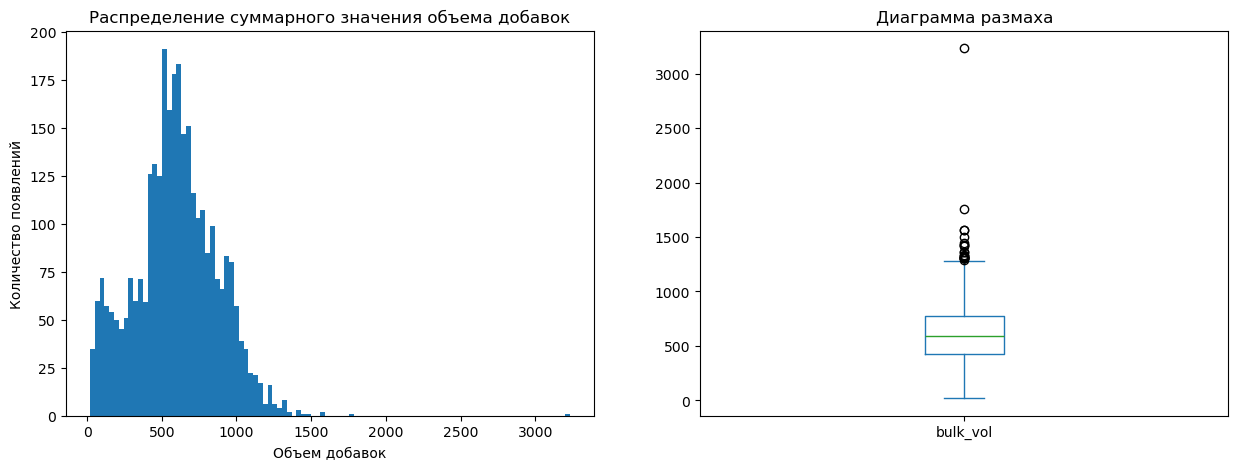

In [55]:
graph_quantity_data(data_bulk, 'bulk_vol', 'Распределение суммарного значения объема добавок', 'Объем добавок')

Аномальных значений не выявлено

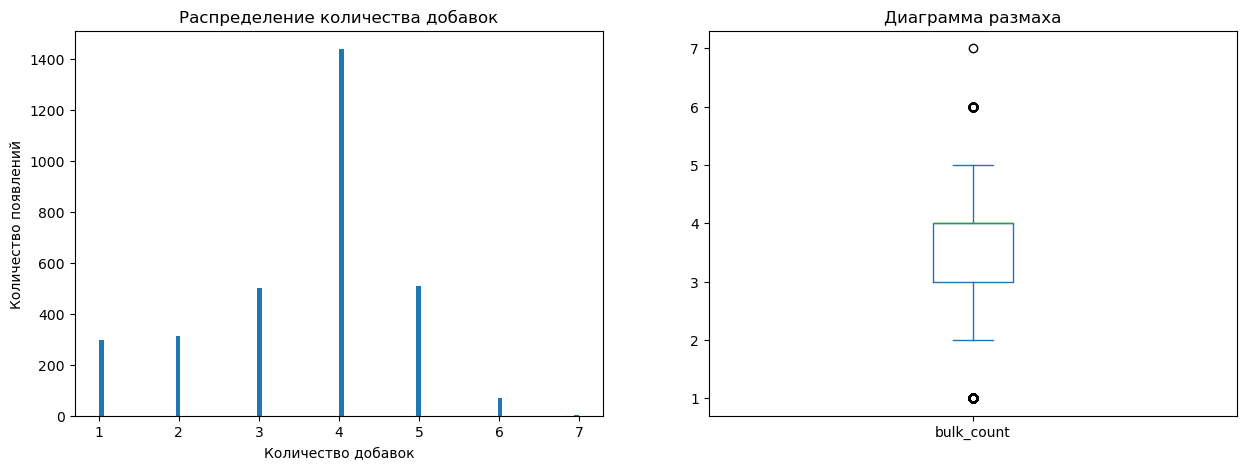

In [56]:
graph_quantity_data(data_bulk, 'bulk_count', 'Распределение количества добавок', 'Количество добавок')

Сформирована таблица data_bulk с данными о добавках в виде сыпучих материалов, аномальные значения из нее удалены. Данные о времени добавления хранящиеся в файле data_bulk_time_new нам не понадобятся, поскольку мы берем медианные значения объема и не выделям отдельные добавки, а ссылаемся только на их медианное значение объема. 

Аналогично поступим с файлами data_wire_new и data_wire_time_new. Сформируем таблицу <b>data_wire</b>, в которой будут храниться данные о добавках проволочных материалов: с номером партии (<b>key</b>), суммарным значением объема добавок (<b>wire_vol</b>) и количеством добавок (<b>wire_count</b>). От данных файла data_wire_time_new также откажемся.

In [57]:
data_wire_new = data_wire_new.set_index('key')

In [58]:
data_wire_new['wire_vol'] = data_wire_new.agg('sum', axis=1)
data_wire_new['wire_count'] = data_wire_new.agg('count', axis=1) - 1
data_wire = data_wire_new.drop(['wire_1_vol', 'wire_2_vol', 'wire_3_vol', 'wire_4_vol', 'wire_5_vol', 'wire_6_vol', 
                                'wire_7_vol', 'wire_8_vol', 'wire_9_vol'], axis=1)
data_wire.head()

,wire_vol,wire_count
key,,
1,60.059998,1
2,96.052315,1
3,91.160157,1
4,89.063515,1
5,98.352796,2


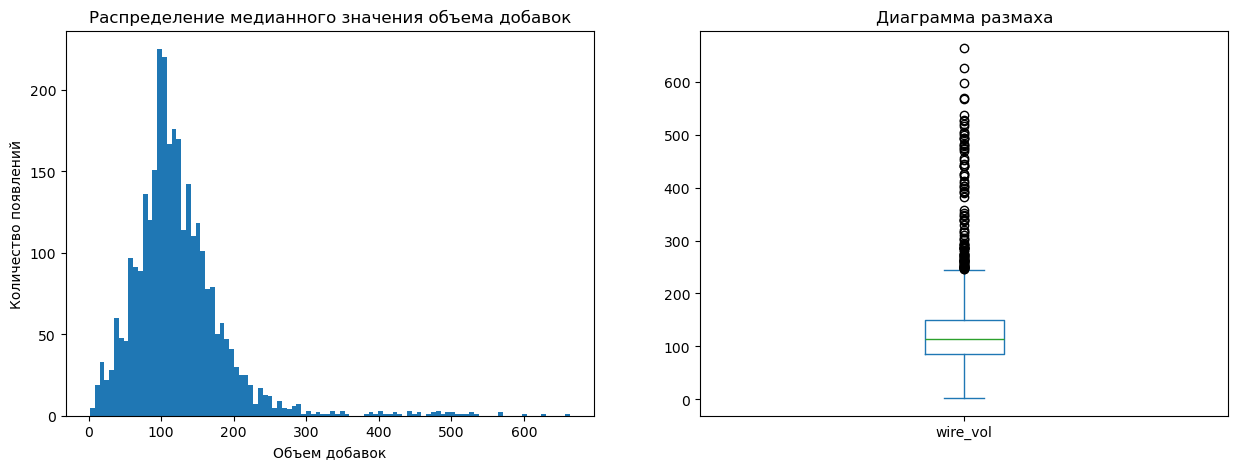

In [59]:
graph_quantity_data(data_wire, 'wire_vol', 'Распределение медианного значения объема добавок', 'Объем добавок')

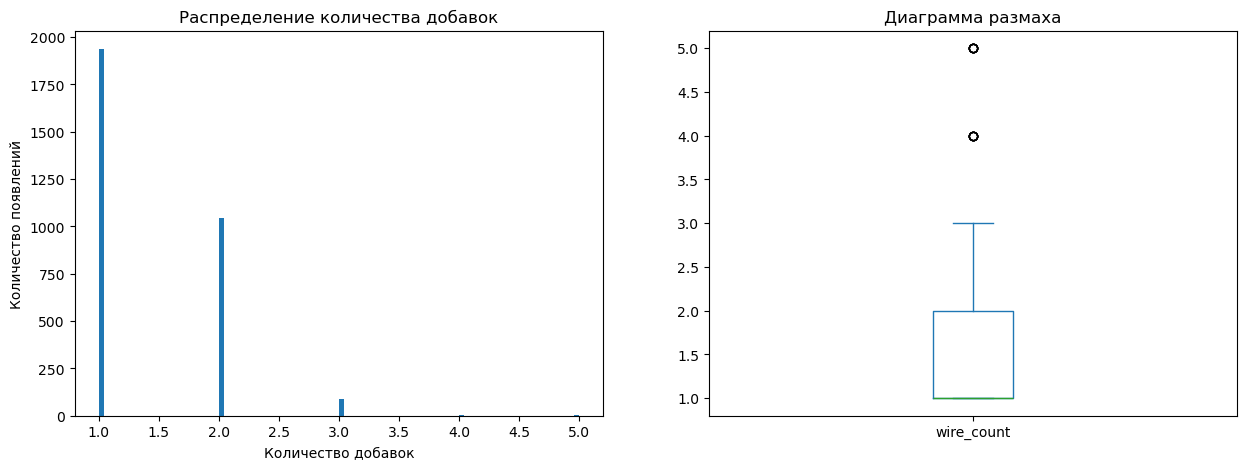

In [60]:
graph_quantity_data(data_wire, 'wire_count', 'Распределение количества добавок', 'Количество добавок')

Аномальных значений в файле data_wire не выявлено

Рассмотрим последний файл с данными data_gas_new

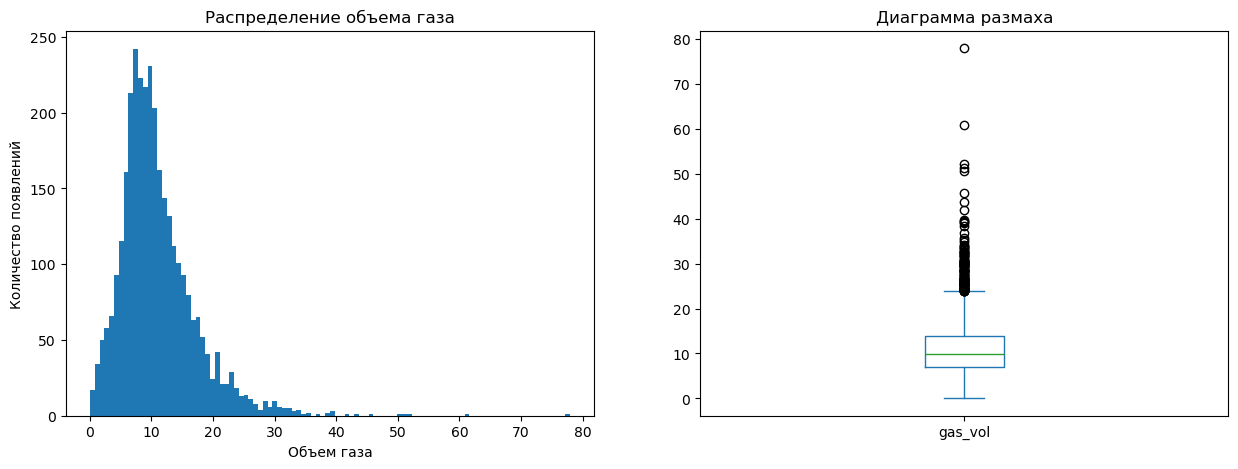

In [61]:
graph_quantity_data(data_gas_new, 'gas_vol', 'Распределение объема газа', 'Объем газа')

Аномальных значений в файле data_gas_new не выявлено

<b>Вывод исследовательского анализа и предобработки данных:</b>
<br><b>Файл data_arc_new.</b> Аномальные значения обнаружены только в параметре реактивной мощности и удалены. Сформирована новая таблица данных <b>data_arc</b> с номером партии <b>key</b>, суммапным значением времени нагрева электродов <b>time_sum</b> и суммарным значением полной мощности <b>power_sum</b>. 
<br><b>Файл data_temp_new.</b> Аномальные значения обнаружены только в параметре температуры и удалены. Также удалены партии, в которых отсутствуют значения послежнего замера температуры, поскольку этот параметр является целевым признаком. Сформирована новая таблица данных <b>data_temp</b> с номером партии <b>key</b>, значением начальной температуры <b>temp_start</b>, значение последнего замера температуры <b>temp_end</b>, разницой времени между первым и последним замером <b>delta_time</b> и количеством промежуточных замеров (без учета первого и последнего) <b>count</b>.
<br>Файлы <b>data_bulk_new.csv</b>. Cформирована новая таблица данных <b>data_bulk</b> с номером партии <b>key</b>, суммарным значением объема добавок <b>bulk_vol</b> и количеством добавок <b>bulk_count</b>. Из признака bulk_vol удалены аномальные значения.
<br>Файлы <b>data_wire_new.csv</b>. Cформирована новая таблица данных <b>data_wire</b> с номером партии <b>key</b>, суммарным значением объема добавок <b>wire_vol</b> и количеством добавок <b>bulk_count</b>. Аномальных значений в новой таблице не обнаружено.
<br>Данные файлов<b>data_bulk_time_new.csv</b> и <b>data_wire_time_new.csv</b> в дальнейшем использоваться не будут, посколько время в которое проводились добавки не важно при рассмотрении суммарных значений.
<br>Файл <b>data_gas_new.csv</b>. Аномальные значения не обнаружены. Новая таблица не создавалась

## ОБЪЕДИНЕНИЕ ДАННЫХ

Объединим ранее полученные данные в единый датафрейм data по номеру партии key

In [62]:
data = pd.merge(data_temp, data_arc, left_index=True, right_index=True)
data = pd.merge(data, data_bulk, left_index=True, right_index=True)
data = pd.merge(data, data_wire, left_index=True, right_index=True)
data = pd.merge(data, data_gas_new, left_index=True, right_index=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2327 entries, 1 to 2499
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   temp_start  2327 non-null   float64
 1   temp_end    2327 non-null   float64
 2   delta_time  2327 non-null   float64
 3   count       2327 non-null   int64  
 4   time_sum    2327 non-null   float64
 5   power_sum   2327 non-null   float64
 6   bulk_vol    2327 non-null   float64
 7   bulk_count  2327 non-null   int64  
 8   wire_vol    2327 non-null   float64
 9   wire_count  2327 non-null   int64  
 10  key         2327 non-null   int64  
 11  gas_vol     2327 non-null   float64
dtypes: float64(8), int64(4)
memory usage: 236.3 KB


<b>Вывод:</b> После объединения данных сформировался датафрэйм с 10 параметрами и 1 целевым признаком (temp_end) из 2327 строк

## ИССЛЕДОВАТЕЛЬСКИЙ АНАЛИЗ И ПРЕДОБРАБОТКА ДАННЫХ ОБЪЕДИНЕННОГО ДАТАФРЭЙМА

После объединения данных в один датафрэйм номер партии для построения модели нам больше не нужен, индексы можно обнулить

In [63]:
data.reset_index(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2327 entries, 0 to 2326
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       2327 non-null   int64  
 1   temp_start  2327 non-null   float64
 2   temp_end    2327 non-null   float64
 3   delta_time  2327 non-null   float64
 4   count       2327 non-null   int64  
 5   time_sum    2327 non-null   float64
 6   power_sum   2327 non-null   float64
 7   bulk_vol    2327 non-null   float64
 8   bulk_count  2327 non-null   int64  
 9   wire_vol    2327 non-null   float64
 10  wire_count  2327 non-null   int64  
 11  key         2327 non-null   int64  
 12  gas_vol     2327 non-null   float64
dtypes: float64(8), int64(5)
memory usage: 236.5 KB


In [64]:
data = data.drop('key', axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2327 entries, 0 to 2326
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       2327 non-null   int64  
 1   temp_start  2327 non-null   float64
 2   temp_end    2327 non-null   float64
 3   delta_time  2327 non-null   float64
 4   count       2327 non-null   int64  
 5   time_sum    2327 non-null   float64
 6   power_sum   2327 non-null   float64
 7   bulk_vol    2327 non-null   float64
 8   bulk_count  2327 non-null   int64  
 9   wire_vol    2327 non-null   float64
 10  wire_count  2327 non-null   int64  
 11  gas_vol     2327 non-null   float64
dtypes: float64(8), int64(4)
memory usage: 218.3 KB


Сначала проверим есть ли повторяющиеся строки.

In [65]:
print('Количество повторяющихся строк в датафрейме data:', 
     data.duplicated().sum())

Количество повторяющихся строк в датафрейме data: 0


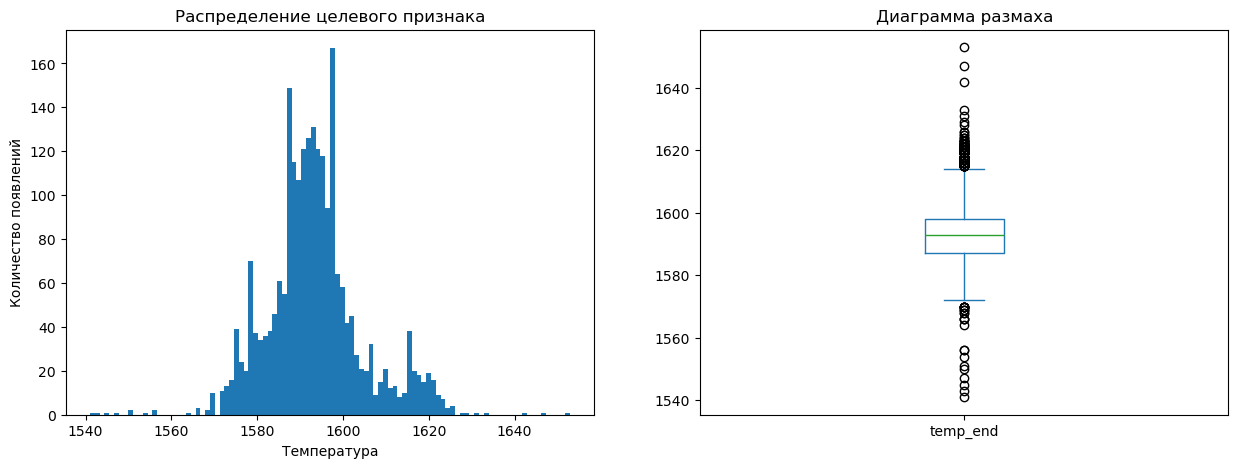

In [66]:
graph_quantity_data(data, 'temp_end', 'Распределение целевого признака', 'Температура')

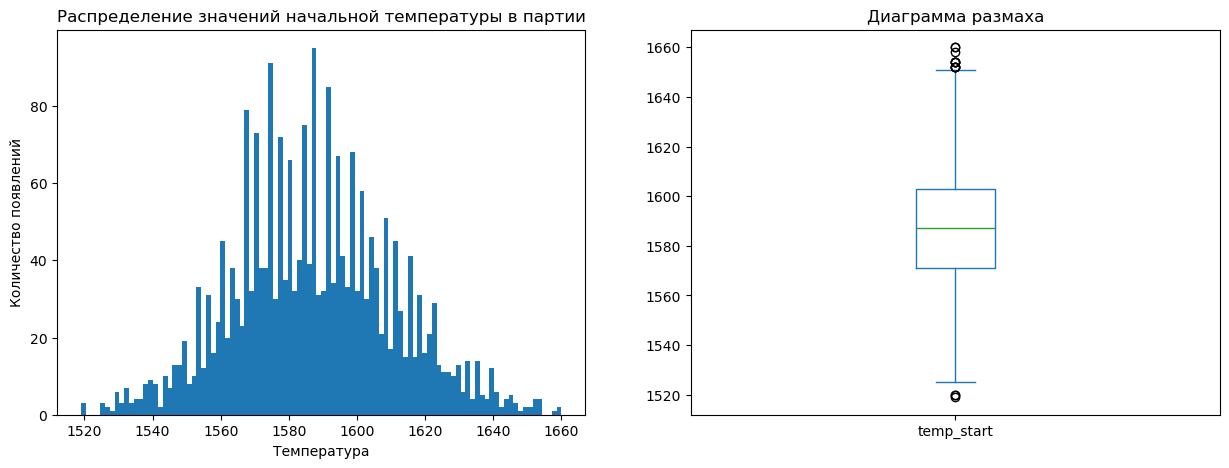

In [67]:
graph_quantity_data(data, 'temp_start', 'Распределение значений начальной температуры в партии', 'Температура')

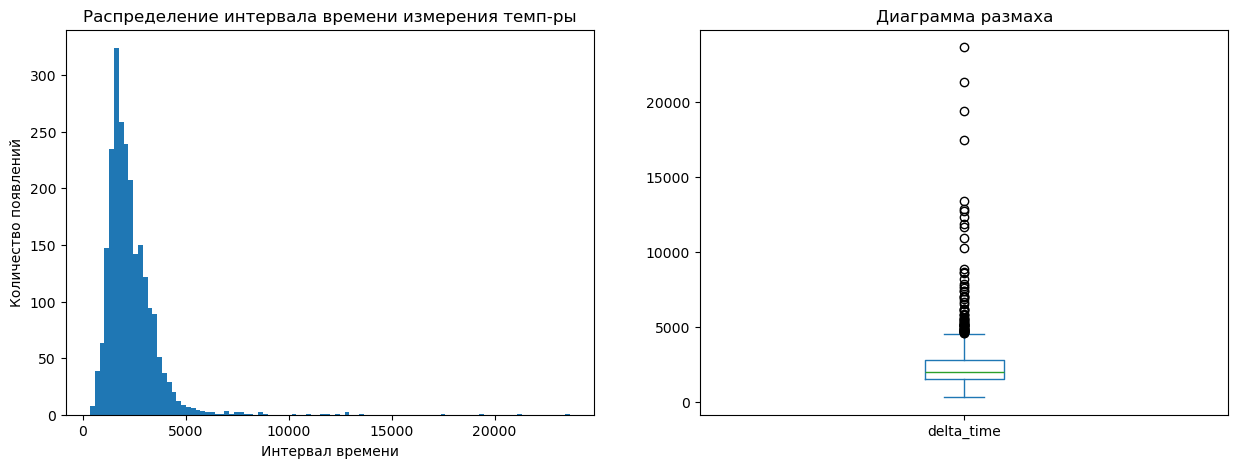

In [68]:
graph_quantity_data(data, 'delta_time', 'Распределение интервала времени измерения темп-ры', 'Интервал времени')

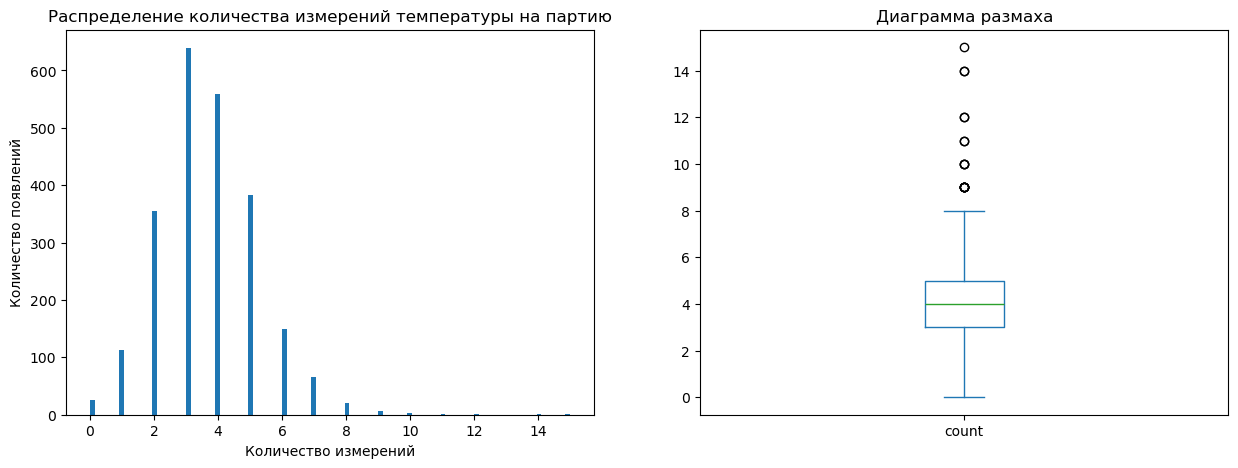

In [69]:
graph_quantity_data(data, 'count', 'Распределение количества измерений температуры на партию', 'Количество измерений')

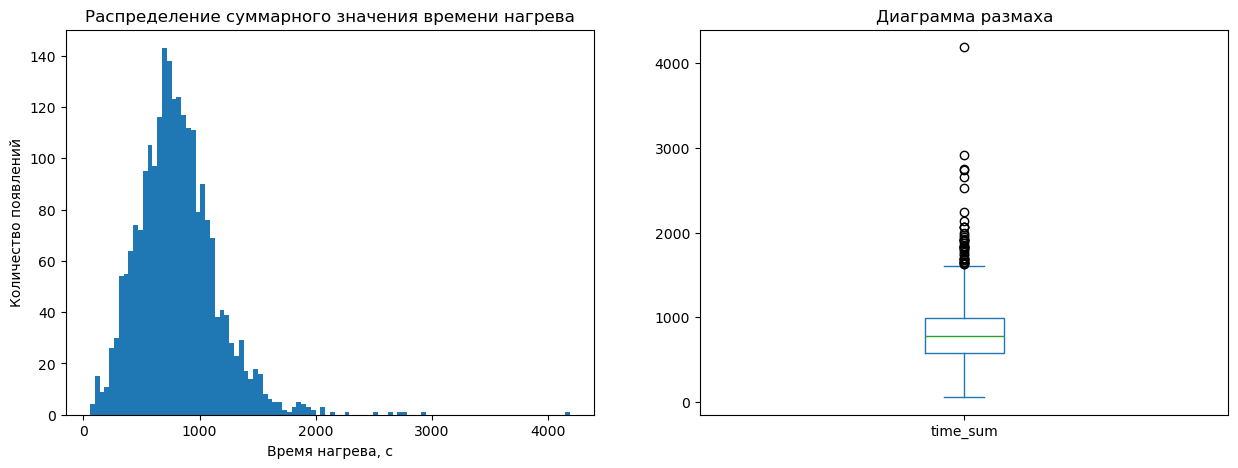

In [70]:
graph_quantity_data(data, 'time_sum', 'Распределение суммарного значения времени нагрева', 'Время нагрева, с')

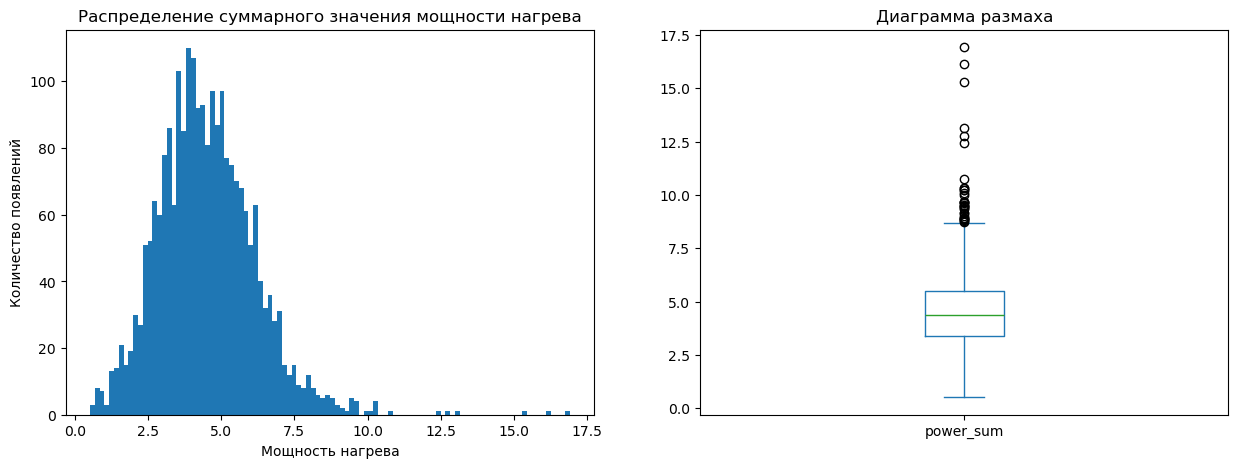

In [71]:
graph_quantity_data(data, 'power_sum', 'Распределение суммарного значения мощности нагрева', 'Мощность нагрева')

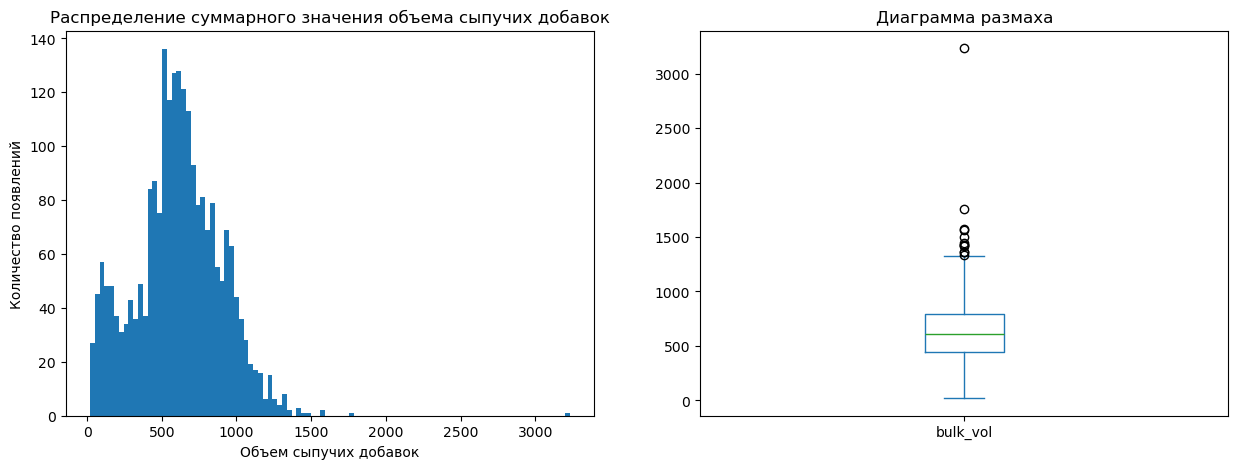

In [72]:
graph_quantity_data(data, 'bulk_vol', 'Распределение суммарного значения объема сыпучих добавок', 'Объем сыпучих добавок')

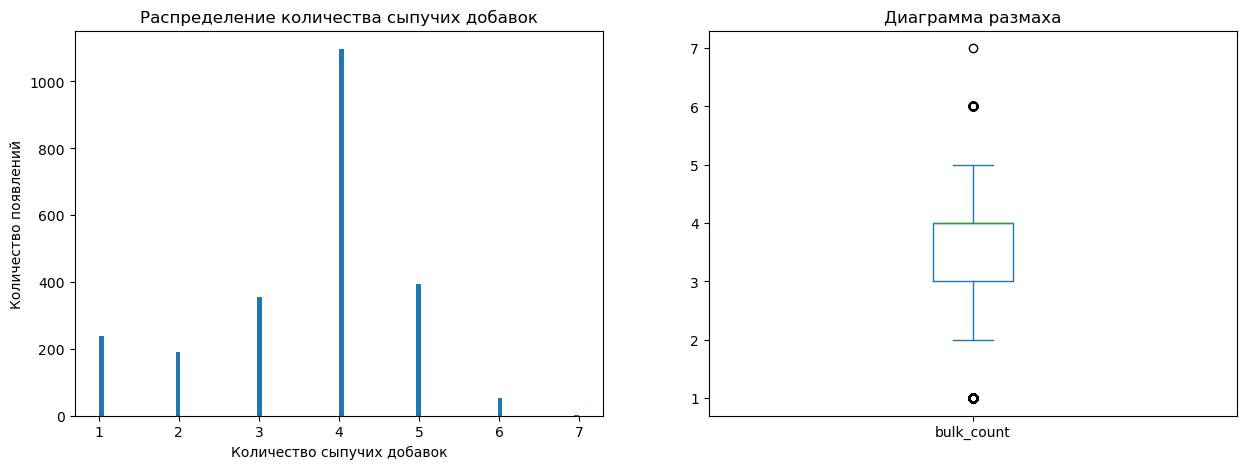

In [73]:
graph_quantity_data(data, 'bulk_count', 'Распределение количества сыпучих добавок', 'Количество сыпучих добавок')

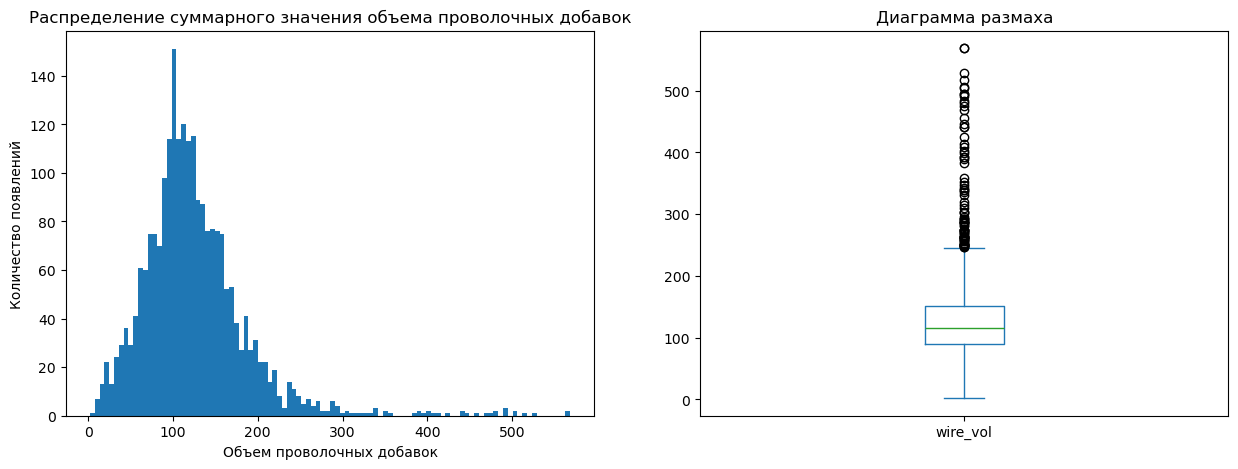

In [74]:
graph_quantity_data(data, 'wire_vol', 'Распределение суммарного значения объема проволочных добавок', 'Объем проволочных добавок')

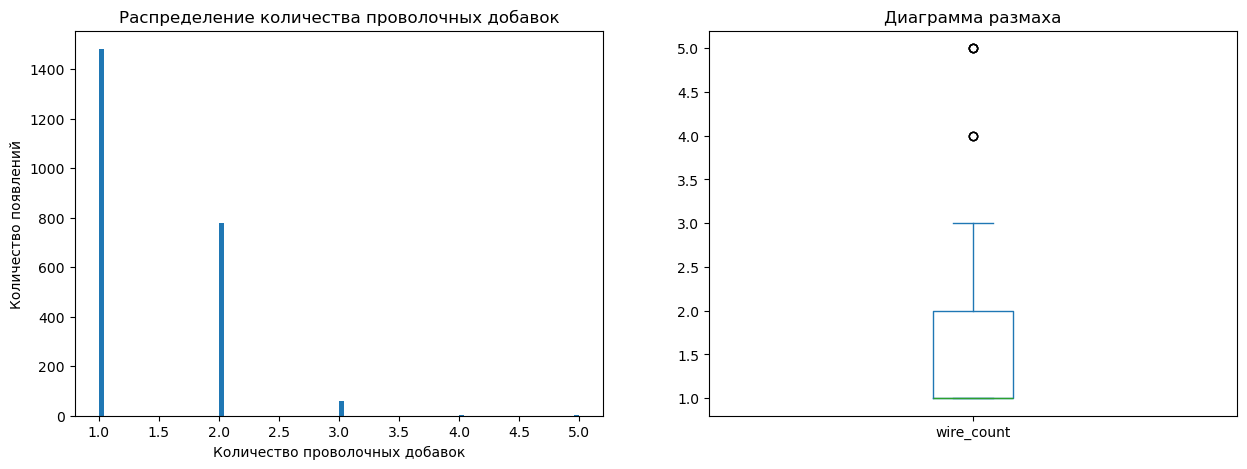

In [75]:
graph_quantity_data(data, 'wire_count', 'Распределение количества проволочных добавок', 'Количество проволочных добавок')

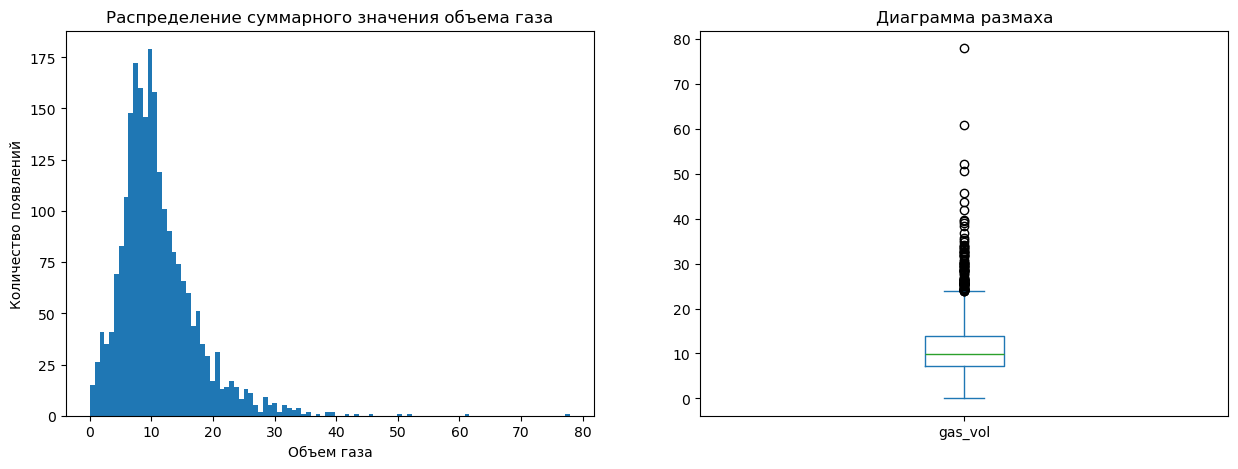

In [76]:
graph_quantity_data(data, 'gas_vol', 'Распределение суммарного значения объема газа', 'Объем газа')

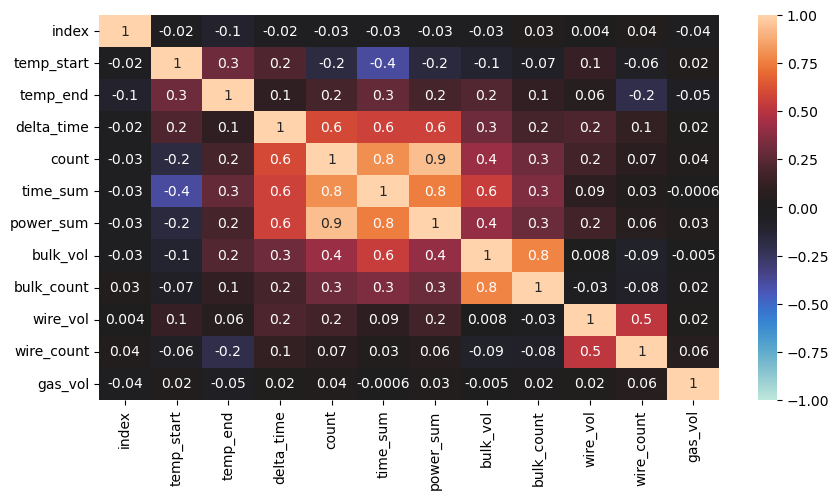

In [77]:
plt.subplots(figsize=(10,5))
sns.heatmap(data.corr(), annot = True, fmt='.1g', vmin=-1, vmax=1, center= 0);

Из матрицы корреляции у целевого признака сильной линейной взаимосвязи нет ни с одним из признаком, средняя линейная связь наблюдается только с начальной измеренной температурой и суммарным временем нагрева.

In [78]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2327 entries, 0 to 2326
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       2327 non-null   int64  
 1   temp_start  2327 non-null   float64
 2   temp_end    2327 non-null   float64
 3   delta_time  2327 non-null   float64
 4   count       2327 non-null   int64  
 5   time_sum    2327 non-null   float64
 6   power_sum   2327 non-null   float64
 7   bulk_vol    2327 non-null   float64
 8   bulk_count  2327 non-null   int64  
 9   wire_vol    2327 non-null   float64
 10  wire_count  2327 non-null   int64  
 11  gas_vol     2327 non-null   float64
dtypes: float64(8), int64(4)
memory usage: 218.3 KB


<b>Вывод:</b> После предобработки данных мы имеем датафрэйм из 11 столбцов с 2327 строками. У целевого признака линейной взаимосвязи ни с одним из параметров не выявлено.

## ПОДГОТОВКА ДАННЫХ

In [79]:
# Отделяем целевой признак от параметров
features = data.drop(['temp_end'], axis=1)
target = data['temp_end']
features

,index,temp_start,delta_time,count,time_sum,power_sum,bulk_vol,bulk_count,wire_vol,wire_count,gas_vol
0,1,1571.0,1714.0,4,1098.0,4.445794,553.0,4,60.059998,1,12.555561
1,2,1581.0,1265.0,3,811.0,3.200241,582.0,4,96.052315,1,28.554793
2,3,1596.0,1753.0,4,655.0,5.562058,544.0,4,91.160157,1,18.841219
3,4,1601.0,1220.0,3,741.0,3.927138,595.0,4,89.063515,1,5.413692
4,5,1576.0,1536.0,3,869.0,3.426655,584.0,4,98.352796,2,11.273392
...,...,...,...,...,...,...,...,...,...,...,...
2322,2495,1570.0,1380.0,3,723.0,4.350117,719.0,5,89.150879,1,14.953657
2323,2496,1554.0,1705.0,5,940.0,5.840638,796.0,5,114.179527,1,11.336151
2324,2497,1571.0,962.0,2,569.0,4.509008,665.0,4,103.134723,2,9.990718
2325,2498,1591.0,1520.0,4,750.0,4.612135,733.0,5,118.110717,1,13.828957


In [80]:
# Делим данные на обучающую и тестовую выборки, от валидационной отказываемся поскольку будем использовать Пайплайн с кросс-валидацией
train_features, test_features, train_target, test_target = train_test_split(features, target, test_size=0.25, random_state=RANDOM_STATE)

## ОБУЧЕНИЕ МОДЕЛЕЙ

Поскольку линейных взаимосвязей у целевого признака с параметрами не выявлено откажемся от линейной модели, соответственно непридется проводить масштабирование и кодирование признаков. Обучать будем модели RandomForestRegressor и CatBoostRegressor.

In [81]:
pipe_final = Pipeline(
    [
        ('models', RandomForestRegressor(random_state=RANDOM_STATE))
    ]
)

In [82]:
param = [
     {
        'models': [RandomForestRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': [3, 5, 7],
        'models__min_samples_leaf': [5, 7]
    },
    {
        'models': [CatBoostRegressor(random_state=RANDOM_STATE, verbose=0)],
        'models__n_estimators': [40, 50],
        'models__learning_rate': [0.3, 0.5]
    }
] 

In [83]:
grid_search = GridSearchCV(pipe_final, param, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [84]:
grid_search.fit(train_features, train_target)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('models',
                                        RandomForestRegressor(random_state=100325))]),
             n_jobs=-1,
             param_grid=[{'models': [RandomForestRegressor(random_state=100325)],
                          'models__max_depth': [3, 5, 7],
                          'models__min_samples_leaf': [5, 7]},
                         {'models': [<catboost.core.CatBoostRegressor object at 0x000001394315CFB0>],
                          'models__learning_rate': [0.3, 0.5],
                          'models__n_estimators': [40, 50]}],
             scoring='neg_mean_absolute_error')

## ВЫБОР ЛУЧШЕЙ МОДЕЛИ

In [85]:
print('Лучшая модель:\n\n', grid_search.best_estimator_)
print('Параметры лучшей модели:', grid_search.best_params_)
print ('Метрика MAE лучшей модели на кросс-валидации:', round((-1)*grid_search.best_score_, 2))

Лучшая модель:

 Pipeline(steps=[('models',
                 <catboost.core.CatBoostRegressor object at 0x0000013943485640>)])
Параметры лучшей модели: {'models': <catboost.core.CatBoostRegressor object at 0x000001394315CFB0>, 'models__learning_rate': 0.3, 'models__n_estimators': 50}
Метрика MAE лучшей модели на кросс-валидации: 6.4


Лучшая метрика (MAE=6.4) на кросс-валидации у модели CatBoostRegressor с параметрами: 'models__learning_rate': 0.3, 'models__n_estimators': 50.
Проверим ее работоспособность на тестовой выборке.

In [86]:
model = CatBoostRegressor(random_state=RANDOM_STATE, verbose=0, learning_rate=0.3, n_estimators=50)

In [87]:
model.fit(train_features, train_target)
pred = model.predict(test_features)
mae = round(mean_absolute_error(pred, test_target), 2)
mae

5.93

На тестовой выборке модель также показала хороший результат: MAE = 5.93, что удовлетворяет условию задачи.

<b>Вывод:</b> лучшей моделью для решения задачи по предсказанию температуры стала модель CatBoostRegressor с параметрами: 'models__learning_rate': 0.3, 'models__n_estimators': 50. На кросс-валидации модель показала лучшую метрику: MAE=6.4, и на тестовой выборке также показала хороший результат: MAE=5.93, удовлетворяющее условию поставленной задачи.   

## АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ

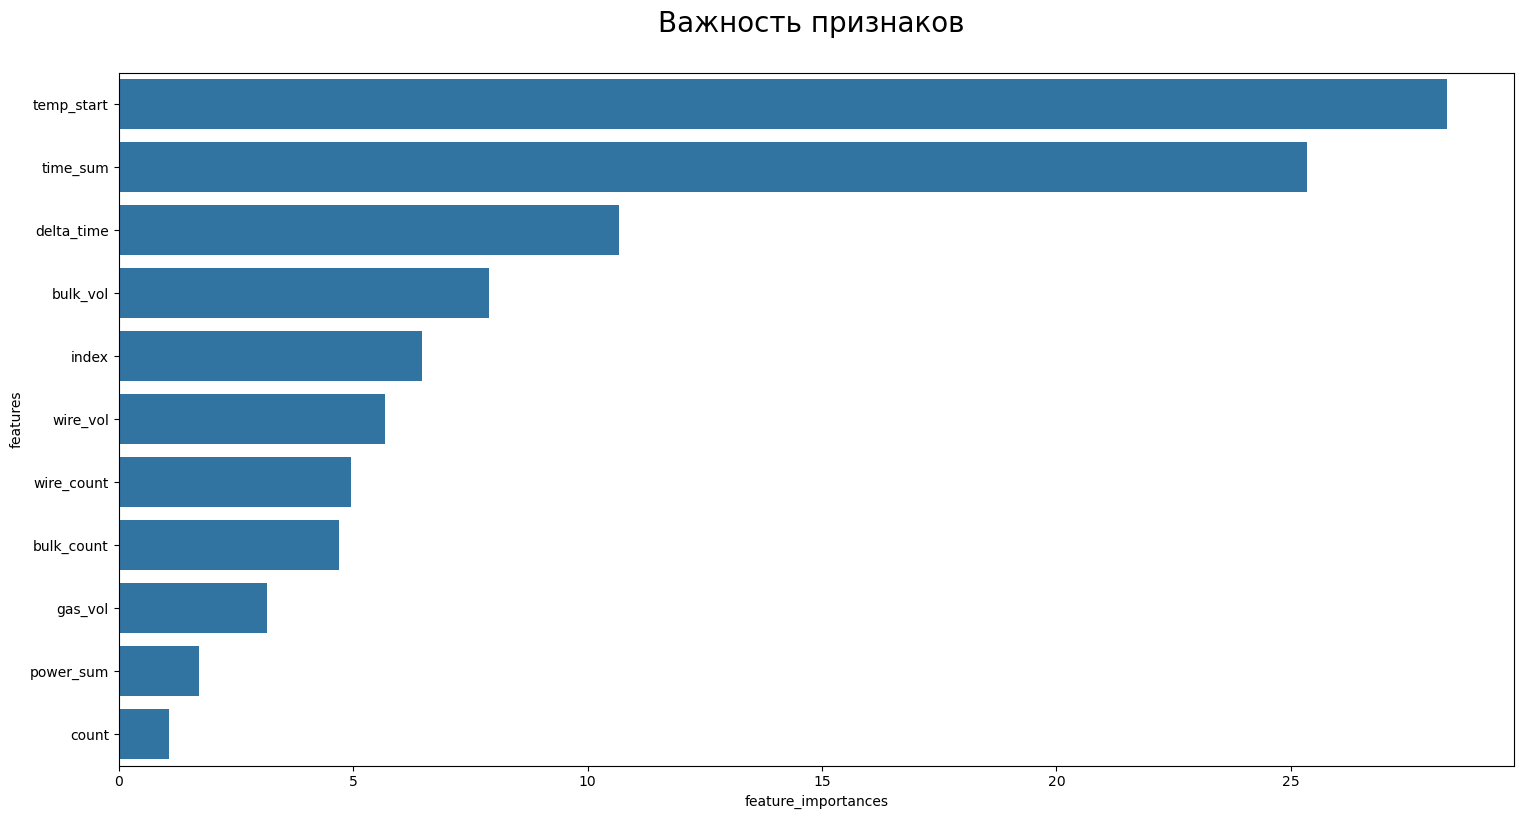

In [88]:
plot_data = {
    'features': test_features.columns,
    'feature_importances': model.feature_importances_,
}
plot_data = pd.DataFrame(plot_data)
plot_data.sort_values(by='feature_importances', ascending=False, inplace=True)
plt.figure(figsize=(18, 9))
sns.barplot(x=plot_data['feature_importances'], y=plot_data['features'])
plt.title('Важность признаков \n', fontsize=20)
plt.show()

<b>ВЫВОД: </b>Наиболее значимыми для обучения модели по предсказанию конечной температуры являются: суммарное время нагрева и начальное значение температуры сплава.

## ПРОВЕРКА МОДЕЛИ НА АДЕКВАТНОСТЬ

Для оценки качества реализованной модели, сравним ее результаты точности с результатами работы базовой модели DummyRegressor. 

In [89]:
dummy_model = DummyRegressor(strategy="median")
dummy_model.fit(train_features, train_target)
pred = dummy_model.predict(test_features)
mae = round(mean_absolute_error(pred, test_target), 2)
mae

7.84

Модель DummyRegressor показала точность работы MAE=7,84. В то время как CatBoostRegressor MAE=5,93. Соответственно модель CatBoostRegressor работает адекватно и позволяет повысить точность прогнозирования конечной температуры сплава почти на 2 градуса.

## ОБЩИЙ ВЫВОД И РЕКОМЕНДАЦИИ ЗАКАЗЧИКУ

В рамках проекта стояла задача построить модель, которая будет предсказывать температуру сплава.
<br>В качестве исходных данных было семь файлов: data_arc_new.csv — с данными об электродах; data_bulk_new.csv — с данными о подаче сыпучих материалов (объём); data_bulk_time_new.csv — с данными о подаче сыпучих материалов (время); data_gas_new.csv — с данными о продувке сплава газом; data_temp_new.csv — c результатами измерения температуры; data_wire_new.csv — с данными о проволочных материалах (объём); data_wire_time_new.csv — с данными о проволочных материалах (время).
<br>В ходе предобработки данных была проведена работа с попусками и удален аномальные значения. 

<br>Сформированы новые таблица данных: 
-<b>data_arc</b> с номером партии <b>key</b>, суммапным значением времени нагрева электродов <b>time_sum</b> и суммарным значением полной мощности <b>power_sum</b>; 
- <b>data_temp</b> с номером партии <b>key</b>, значением начальной температуры <b>temp_start</b>, значение последнего замера температуры <b>temp_end</b>, разницой времени между первым и последним замером <b>delta_time</b> и количеством промежуточных замеров (без учета первого и последнего) <b>count</b>;
- <b>data_bulk</b> с номером партии <b>key</b>, суммарным значением объема добавок <b>bulk_vol</b> и количеством добавок <b>bulk_count</b>;
- <b>data_wire</b> с номером партии <b>key</b>, суммарным значением объема добавок <b>wire_vol</b> и количеством добавок <b>bulk_count</b>. 
<br>Данные файлов<b>data_bulk_time_new.csv</b> и <b>data_wire_time_new.csv</b> не использовались, посколько время в которое проводились добавки не важно при рассмотрении суммарных значений.
<br>Файл <b>data_gas_new.csv</b> использовался без изменения формирования новой таблицы.

После объединения данных по номеру партии сформировался датафрэйм с 10 параметрами и 1 целевым признаком (temp_end) из 2327 строк. Номер партии в дальнейшем был исключен из датафрэйма поскольку не несет информации для предсказания температуры.

Поскольку линейных взаимосвязей у целевого признака с параметрами не было выявлено отказались от линейной модели, поэтому не проводилось масштабирование и кодирование признаков. Обучались модели RandomForestRegressor и CatBoostRegressor.

Реализованный Пайплайн позволил выявить лучшую модель: <b>CatBoostRegressor</b>. 
<br> Поэтому для решения задачи по предсказанию температуры рекомендуется модель <b>CatBoostRegressor с параметрами: 'models__learning_rate': 0.3, 'models__n_estimators': 50</b>. На кросс-валидации модель показала лучшую метрику: MAE=6.4, и на тестовой выборке также показала хороший результат: <b>MAE=5.93</b>, удовлетворяющее условию поставленной задачи. 

Также сравнение с результатами работы базовой модели DummyRegressor подтвердило адекватность работы реализованной модели CatBoostRegressor.

Последующий анализ наиболее значимых для обучения модели параметров позволил выделить два основных параметра: суммарное время нагрева и начальное значение температуры сплава. Именно на эти два параметра следует обращать основное внимание заказчику при реализации техпроцесса.